In [1]:
import os
from pathlib import Path
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import PIL
from PIL import Image
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.models.resnet import resnet18
from torchvision.models.vgg import vgg19
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d:\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='cuda')

In [3]:
# !pip install fastai==2.4
from fastai.vision.learner import create_body
from fastai.vision.models.unet import DynamicUnet
from fastai.data.external import untar_data, URLs
from fastai.vision.all import *

path = untar_data(URLs.COCO_SAMPLE)
path = str(path) + "/train_sample"
paths = glob.glob(path + "/*.jpg")

In [17]:
class Config:
    external_data_size = 10000
    train_size = 8000
    image_size_1 = 256
    image_size_2 = 256
    batch_size = 1
    LeakyReLU_slope = 0.2
    dropout = 0.5
    kernel_size = 4
    stride = 2
    padding = 1
    gen_lr = 2e-4
    disc_lr = 2e-4
    beta1 = 0.5
    beta2 = 0.999
    lambda_l1 = 100
    gan_mode = 'vanilla'
    layers_to_cut = -2
    epochs = 20
    pretrain_lr = 1e-4

In [18]:
# Train test split
np.random.seed(42)
paths_subset = np.random.choice(paths, Config.external_data_size, replace=False) # choosing 10000 images randomly
random_idxs = np.random.permutation(Config.external_data_size) 
train_idxs = random_idxs[:Config.train_size] # choosing the first 8000 as training set
val_idxs = random_idxs[Config.train_size:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]

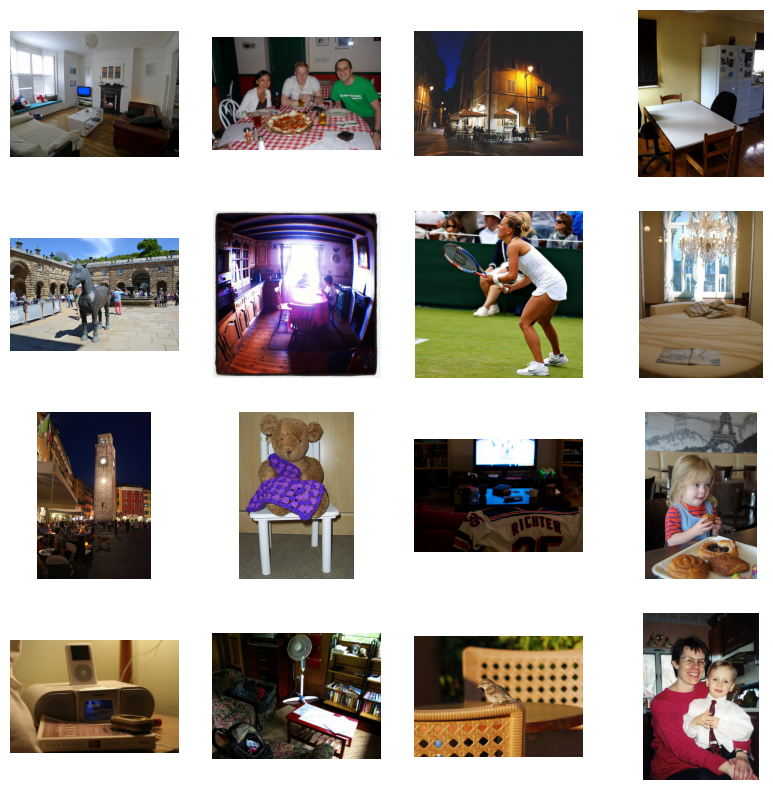

In [19]:
# Taking a look at the training dataset
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [20]:
class ImageDataset(Dataset):
    ''' 
    
    Class that deals with the Data Loading and preprocessing steps such as image resizing, data augmentation (horizontal flip) 
    and conversion of RGB image to LAB color space with standardization.
    
    '''
    
    def __init__(self,paths,train = True):
        if train == True:
            self.transforms = transforms.Compose([transforms.Resize((Config.image_size_1,Config.image_size_2)),
                                                 transforms.RandomHorizontalFlip()]) # Basic Data Augmentation
        elif train == False:
            self.transforms = transforms.Compose([transforms.Resize((Config.image_size_1,Config.image_size_2))])
            
        self.train = train
        self.paths = paths
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        lab = rgb2lab(img).astype("float32")
        lab = transforms.ToTensor()(lab)
        L = lab[[0],...]/50 - 1 # Standardizing L space
        ab = lab[[1,2],...]/128 # Standardizing ab space
        
        return {'L': L,
                'ab': ab}

In [21]:
batch_size = Config.batch_size

#train dataset
train_data = ImageDataset(paths = train_paths, train=True)
# validation dataset
valid_data = ImageDataset(paths = val_paths, train=False)
# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size,shuffle=True,pin_memory = True)
# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size,shuffle=False,pin_memory = True)

In [22]:
# Credits: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

class AverageMeter:
    '''
    
    Computes and stores the average and current value for the various losses involved.
    
    '''
    
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    disc_loss_gen = AverageMeter()
    disc_loss_real = AverageMeter()
    disc_loss = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'disc_loss_gen': disc_loss_gen,
            'disc_loss_real': disc_loss_real,
            'disc_loss': disc_loss,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)
        


def lab_to_rgb(L, ab):
    """
    
    Takes a batch of images and converts from LAB space to RGB
    
    """
    
    L = (L + 1.) * 50
    ab = ab * 128
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    '''
    
    Function which helps visualize and see the difference between the input image (grayscale), generated image 
    and the Real image.
    
    '''
    
    model.generator.eval()
    with torch.no_grad():
        model.prepare_input(data)
        model.forward()
#     model.generator.train()
    fake_color = model.gen_output.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")
        

class GANLoss(nn.Module):
    '''
    
    Class that defines the GAN loss.
    
    '''
    
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [23]:
# Code help for model architecture and training loop: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

class UnetBlock(nn.Module):
    '''
    
    Class that helps define the various different types of blocks used in the Generator architecture
    
    '''
    
    def __init__(self, nf, ni, submodule=None, input_channels=None, dropout=False,innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_channels is None: 
            input_channels = nf
        downconv = nn.Conv2d(input_channels, ni, kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding, bias=False)
        downrelu = nn.LeakyReLU(Config.LeakyReLU_slope, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf,kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(Config.dropout)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    '''
    
    The Generator Model Class
    
    '''
    
    def __init__(self, input_channels=1, output_channels=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_channels, out_filters, input_channels=input_channels, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [24]:
class Discriminator(nn.Module):
    '''
    
    The Discriminator Model Class
    
    '''
    
    def __init__(self,input_channels,num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_channels,num_filters,norm = False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), stride=1 if i == (n_down-1) else 2) for i in range(n_down)]
        model += [self.get_layers(num_filters * 2 ** n_down, 1, stride=1, norm=False, activation=False)] 
        self.model = nn.Sequential(*model)
    
    def get_layers(self, ni, nf, kernel_size=Config.kernel_size, stride=Config.stride, padding=Config.padding, norm=True, activation=True): 
        layers = [nn.Conv2d(ni, nf, kernel_size, stride, padding, bias=not norm)]          
        if norm: 
            layers += [nn.BatchNorm2d(nf)]
        if activation:
            layers += [nn.LeakyReLU(Config.LeakyReLU_slope, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [25]:
# Normal Weight Initialization with mean = 0, std = 0.02

def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [26]:
def build_backbone_unet(input_channels=1, output_channels=2, size=Config.image_size_1):
    '''
    
    Function that helps build the generator backbone using another pretrained model trained on imagenet for image classification
    
    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18(), pretrained=True, n_in=input_channels, cut=Config.layers_to_cut)
    generator = DynamicUnet(body, output_channels, (size, size)).to(device)
    return generator

def pretrain_generator(generator, train_dl, opt, criterion, epochs):
    '''
    
    Function to pretrain the generator in a supervised manner on the colorization task using L1 Loss.
    
    '''
    
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = generator(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

In [27]:
class MainModel(nn.Module):
    '''
    
    The Class where it all comes together.
    
    '''
    
    def __init__(self,generator = None,gen_lr =Config.gen_lr,disc_lr = Config.disc_lr, beta1 = Config.beta1,beta2 = Config.beta2, lambda_l1 = Config.lambda_l1):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_l1 = lambda_l1
        
        if generator is None:
            self.generator = init_model(Unet(input_channels=1, output_channels=2, n_down=8, num_filters=64),self.device)
        else:
            self.generator = generator.to(self.device)
        self.discriminator = init_model(Discriminator(input_channels = 3,num_filters = 64,n_down = 3),self.device)
        self.GANloss = GANLoss(gan_mode=Config.gan_mode).to(self.device)
        self.L1loss = nn.L1Loss()
        self.gen_optim = optim.Adam(self.generator.parameters(), lr=gen_lr, betas=(beta1, beta2))
        self.disc_optim= optim.Adam(self.discriminator.parameters(), lr=disc_lr, betas=(beta1, beta2))
        
    def requires_grad(self,model,requires_grad = True):
        for p in model.parameters():
            p.requires_grad = requires_grad
            
    def prepare_input(self,data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.gen_output = self.generator(self.L)
        
    def disc_backward(self):
        gen_image = torch.cat([self.L, self.gen_output], dim=1)
        gen_image_preds = self.discriminator(gen_image.detach())
        self.disc_loss_gen = self.GANloss(gen_image_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.discriminator(real_image)
        self.disc_loss_real = self.GANloss(real_preds, True)
        self.disc_loss = (self.disc_loss_gen + self.disc_loss_real) * 0.5
        self.disc_loss.backward()
    
    def gen_backward(self):
        gen_image = torch.cat([self.L, self.gen_output], dim=1)
        gen_image_preds = self.discriminator(gen_image)
        self.loss_G_GAN = self.GANloss(gen_image_preds, True)
        self.loss_G_L1 = self.L1loss(self.gen_output, self.ab) * self.lambda_l1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.discriminator.train()
        self.requires_grad(self.discriminator, True)
        self.disc_optim.zero_grad()
        self.disc_backward()
        self.disc_optim.step()
        
        self.generator.train()
        self.requires_grad(self.discriminator, False) 
        self.gen_optim.zero_grad()
        self.gen_backward()
        self.gen_optim.step()

In [28]:
def train_model(model, train_loader, epochs, display=100):
    data = next(iter(train_loader)) 
    for epoch in range(epochs):
        loss_meter_dict = create_loss_meters() 
        i=0
        for data in tqdm(train_loader):
            model.prepare_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) 
            i+=1
            if i % display == 0:
                print(f"\nEpoch {epoch+1}/{epochs}")
                print(f"Iteration {i}/{len(train_loader)}")
                log_results(loss_meter_dict) 
                visualize(model, data, save=False) 

In [ ]:
generator = build_backbone_unet(input_channels=1, output_channels=2, size=Config.image_size_1)
opt = optim.Adam(generator.parameters(), lr=Config.pretrain_lr)
loss = nn.L1Loss()        
pretrain_generator(generator, train_loader, opt, loss, Config.epochs)
torch.save(generator.state_dict(), "res18-unet.pt")
generator.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(generator=generator)
train_model(model, train_loader, Config.epochs)
torch.save(model.state_dict(), "main-model.pt")

In [ ]:
path = "Path to Image"
img = PIL.Image.open(path)
img = img.resize((256, 256))
img = transforms.ToTensor()(img)[:1] * 2. - 1.
model.eval()
with torch.no_grad():
    preds = model.generator(img.unsqueeze(0).to(device))
    gen_output = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
plt.imshow(img)
plt.imshow(gen_output)